In [2]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/85/15/cf99a373812d37f8ae99752a34a9f5f690d820ceb5b302e922705bc18944/tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorflow-macos==2.15.0 from https://files.pythonhosted.org/packages/eb/9f/0759e2fea4a3c48f070b64811c2c57036b46353ba87263afc810b8f4188a/tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-no

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
os.getcwd()

'/Users/maniksinghsarmaal/Downloads/s_bin'

In [3]:
# Define the path where our dataset is stored
dataset_path = '/Users/maniksinghsarmaal/Downloads/TrashType_Image_Dataset'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

paper folder contains 594 images.
metal folder contains 410 images.
cardboard folder contains 403 images.
trash folder contains 137 images.
glass folder contains 501 images.
plastic folder contains 482 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


In [4]:
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        

paper folder contains 594 images.
metal folder contains 410 images.
cardboard folder contains 403 images.
trash folder contains 137 images.
glass folder contains 501 images.
plastic folder contains 482 images.


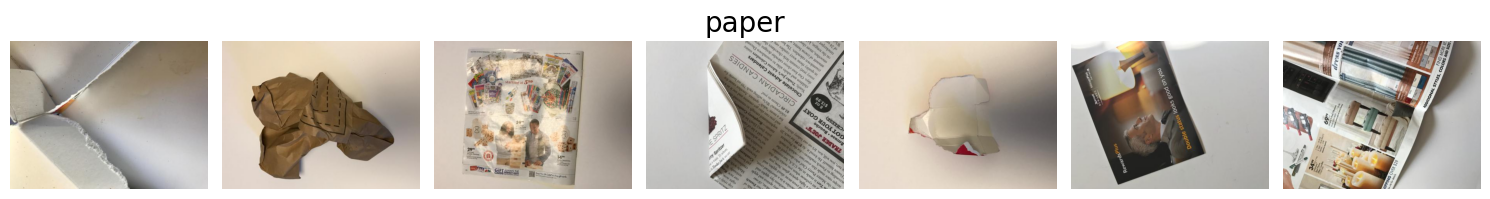

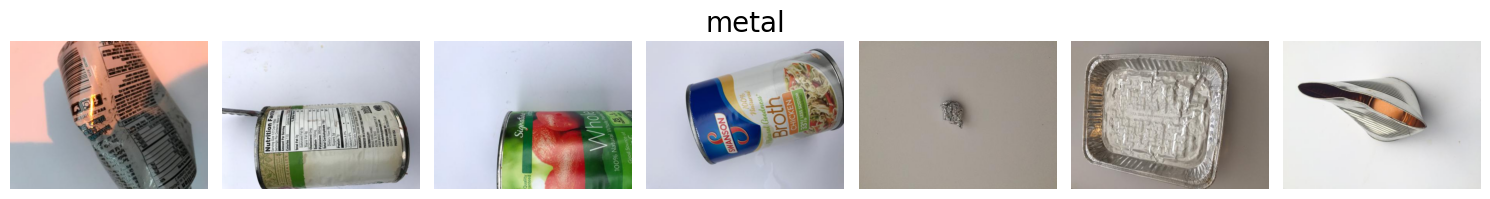

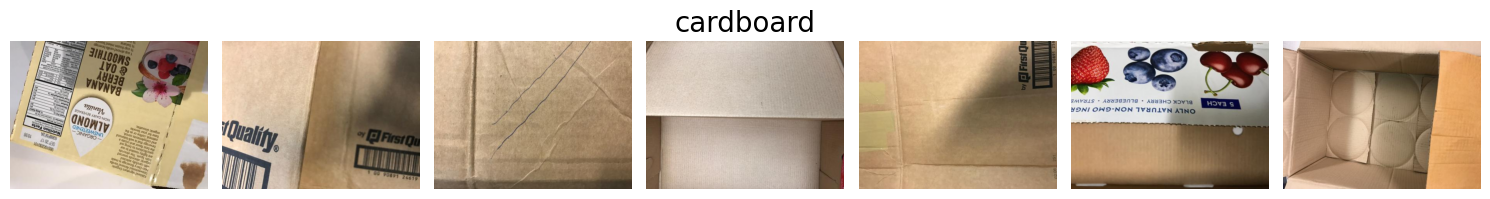

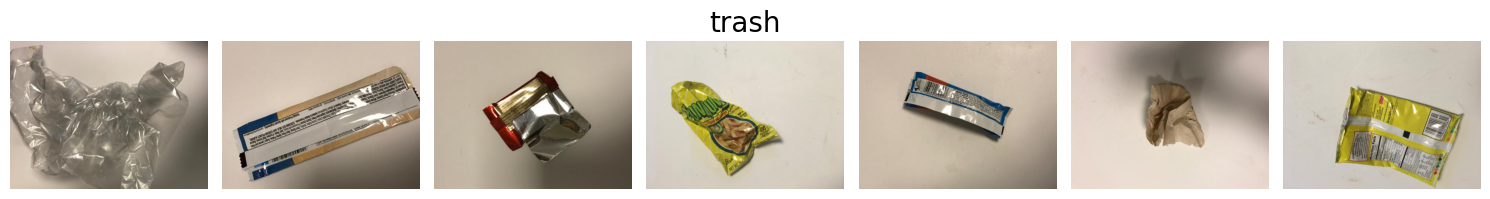

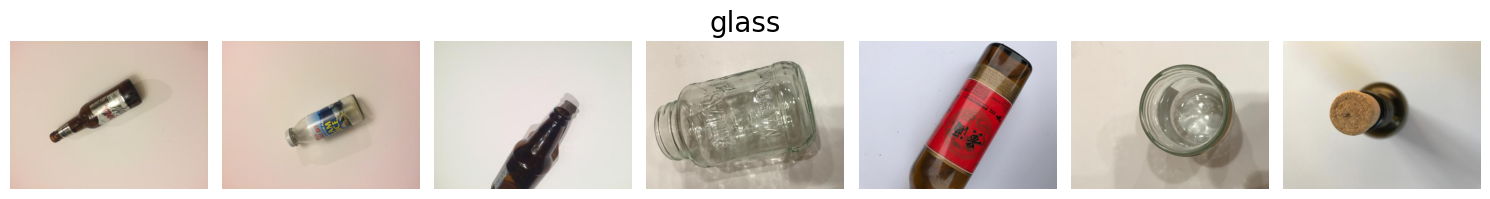

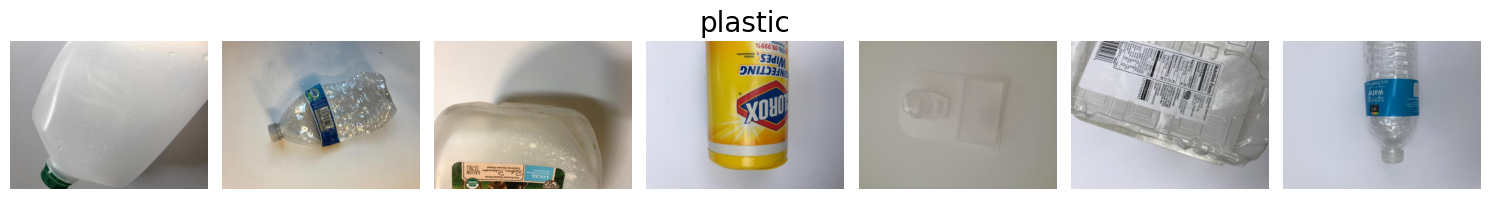

In [5]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Select the first 10 images
        image_files = image_files[:7]
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

In [6]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    garbage_type_path = os.path.join(dataset_path, garbage_type)
    
    # Check if the entry is a directory
    if os.path.isdir(garbage_type_path): # <----- just to make sure to handle error of .DSstore is not a directory
        for file in os.listdir(os.path.join(dataset_path, garbage_type)):
            # Append the image file path and its trash type (as a label) to the data list
            data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,/Users/maniksinghsarmaal/Downloads/TrashType_I...,paper
1,/Users/maniksinghsarmaal/Downloads/TrashType_I...,paper
2,/Users/maniksinghsarmaal/Downloads/TrashType_I...,paper
3,/Users/maniksinghsarmaal/Downloads/TrashType_I...,paper
4,/Users/maniksinghsarmaal/Downloads/TrashType_I...,paper


In [7]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

Number of images in the training set: 2021
Number of images in the validation set: 506


In [8]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [9]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [11]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [12]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [13]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [14]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [15]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [16]:
#implementing resnet50 block structure
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.
    
    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth; 
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer
    
    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. We will need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [17]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [18]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3 
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4 
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5 
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)
    
    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)
    
    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)
        
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model

In [19]:
# Define the shape of the input images and number of classes
input_shape = (384, 384, 3)
num_classes = 6

# Initialize the modified ResNet50 model with the specified parameters
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

In [20]:
modified_resnet50_model.summary()

Model: "Modified_ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 189, 189, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 189, 189, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 189, 189, 64)         0         ['batch_normal

In [21]:
modified_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)

In [55]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [23]:
# Total number of epochs
num_epochs = 50

# Train the model
history = modified_resnet50_model.fit(train_generator, 
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs, 
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/50
64/64 [==============================] - 2442s 38s/step - loss: 2.1313 - accuracy: 0.3647 - val_loss: 258.4113 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2771s 43s/step - loss: 1.7539 - accuracy: 0.4146 - val_loss: 39.2479 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 3401s 53s/step - loss: 1.6924 - accuracy: 0.4334 - val_loss: 489.6769 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2924s 46s/step - loss: 1.5421 - accuracy: 0.4547 - val_loss: 22.9351 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 14012s 222s/step - loss: 1.5700 - accuracy: 0.4641 - val_loss: 4.4414 - val_accuracy: 0.1621 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2099s 31s/step - loss: 1.8790 - accuracy: 0.4067 - val_loss: 2517.3213 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 2

KeyboardInterrupt: 

In [25]:
model = modified_resnet50_model
# Save the model
model.save("sbinv2_model.h5")


In [24]:
os.getcwd()

'/Users/maniksinghsarmaal/Downloads/s_bin'

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("/Users/maniksinghsarmaal/Downloads/s_bin/sbinv2_model.h5")



In [31]:
from PIL import Image
import numpy as np

# Load the image and resize it
image_path = '/Users/maniksinghsarmaal/Downloads/Unbreakable-Plastic-Bottle.jpg'
img = Image.open(image_path)
img = img.resize((384, 384))

# Convert the image to a NumPy array
img_array = np.array(img)
img_array = img_array.reshape(1, 384, 384, 3)  # Reshape to match the model's input shape

# Preprocess the image and make predictions
img_array = preprocess_input(img_array)
predictions = loaded_model.predict(img_array)


1/1 [==============================] - 1s 666ms/step


In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Load the saved model
loaded_model = load_model("/Users/maniksinghsarmaal/Downloads/s_bin/sbinv2_model.h5")

# Load and preprocess an image for prediction
image_path = '/Users/maniksinghsarmaal/Downloads/images.jpeg'
img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

# Make predictions on the preprocessed image
predictions = loaded_model.predict(img)

# Decode and print the top-3 predicted classes
decoded_predictions = decode_predictions(predictions, top=3)[0]
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


ValueError: in user code:

    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/maniksinghsarmaal/mambaforge3/envs/sbin/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "Modified_ResNet50" is incompatible with the layer: expected shape=(None, 384, 384, 3), found shape=(None, 224, 224, 3)
